# Image Denoising

<img src="img/example2.png" width="500">
<img src="img/example1.png" width="400">

Image, especially photographs, are very susceptible to noise. Noise can be caused by countless factors, such as lighting conditions, sensor limitations, or transmission errors.

Machine learning techniques, particularly autoencoders, have become one of the most popular methods for image denoising. In this project, I aim to develop a pseudo-autoencoder using statistical methods we have learned to tackle image noise.

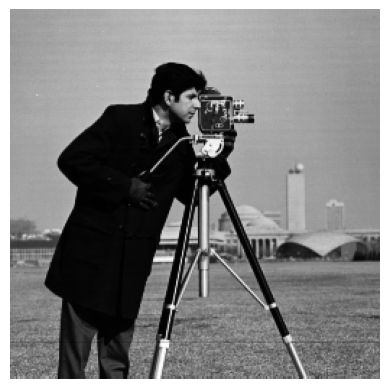

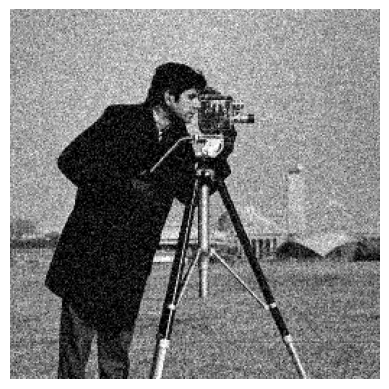

In [31]:
from src.utils import *

original_image = load_image("src/data/grey12_1/camera.tif")
show_image(original_image)

original_image = add_noise(original_image, noise_level=25)
show_image(original_image)

## Autoencoder

<img src="img/ae.png" width="500">

Autoencoder is a type of neural network that learns to compress data (encoding) and then reconstruct the data back (decoding).

The bottleneck layer in between the encoding and decoding layers is where the data is compressed. The dimensionality of the bottleneck layer is usually lower than the input and output layers. This difference in the dimensionality forces the network to learn the most important features of the data and discard the noise. The compressed latent representation is then used to reconstruct the original data.

Typically, the original data to be compressed by the encoder consists of features learned from the neural network layers. The encoder and decoder also consists of multiple layers of neurons. The weights of the neurons are learned using the training data.

## Pseudo-Autoencoder

Neural networks can be computationally expensive for both training and inference, especially for large datasets. They also require a lot of hyperparameter tuning, can be sensitive to the choice of architecture, and require a lot of data to train. 

In this project, I will use statistical methods to create a pseudo-autoencoder that can achieve similar results without the need for a neural network or machine learning.

### Encoder

- The encoder is responsible for transforming the input data (in this case, noisy images) into a compressed latent representation.

- Mathematically, the encoder is a function $f_{encoder}(X)$, where X is the noisy input image. This function maps the input to a lower-dimensional latent space, reducing the image's dimensionality. In the case of a pseudo-autoencoder, instead of relying solely on a neural network, we incorporate statistical techniques to extract meaningful trends that best represent the image while minimizing noise.

- The key here is that the encoder not only compresses the data but also learns to emphasize the most important aspects of the image, ensuring that critical features are preserved for reconstruction.


In [2]:
class Encoder:
    """
    Encoder base class setup
    """
    def __init__(self):
        pass
    
    def encode(self, image):
        """
        Encode the image to create a latent representation.
        Returns the latent representation (np.ndarray) and the binary outliers mask (np.ndarray).
        """
        pass

#### Mean Encoder

As the simplest approach, I implemented a mean encoder. It takes the mean of the pixel values in a local neighborhood around each pixel. This helps to smooth out noise while preserving the overall structure of the image.

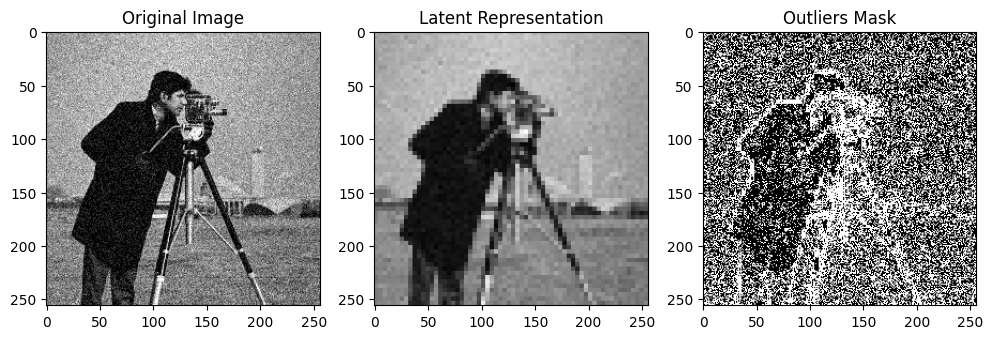

In [3]:
class MeanEncoder(Encoder):
    def __init__(self, patch_size=8, threshold=20):
        self.patch_size = patch_size
        self.threshold = threshold
    
    def encode(self, image):
        h, w = image.shape
        latent_representation = np.zeros_like(image)
        outliers_mask = np.zeros_like(image, dtype=np.uint8)
        
        for i in range(0, h, self.patch_size):
            for j in range(0, w, self.patch_size):
                patch = image[i:i+self.patch_size, j:j+self.patch_size]
                patch_mean = np.mean(patch)
                
                latent_representation[i:i+self.patch_size, j:j+self.patch_size] = patch_mean
                
                residuals = np.abs(patch - patch_mean)
                outlier_patch = (residuals > self.threshold).astype(np.uint8)
                outliers_mask[i:i+self.patch_size, j:j+self.patch_size] = outlier_patch
        
        return latent_representation.astype(np.uint8), outliers_mask
    
encoder = MeanEncoder(patch_size=4)
latent_representation, outliers_mask = encoder.encode(original_image)
plot_images(original_image, latent_representation, outliers_mask, titles=["Original Image", "Latent Representation", "Outliers Mask"])

#### RANSAC Encoder

RANSAC (Random Sample Consensus) is an iterative algorithm used to estimate the parameters of a mathematical model from a set of observed data. The algorithm selects a random subset of the data, fits the model to the subset, and then tests the model on the remaining data. This process helps to identify the outliers in the data, which does not fit to the trend of the data. 

A detailed steps of RANSAC algorithm is as follows:
1. Select a random subset of data points to be *hypothetical inliers*
2. Fit the model to the set of *hypothetical inliers*.
3. Test all other data points against the fitted model. The points that fit well to the model are considered as *inliers*, and called the *consensus set*.
4. Refit the model using all *inliers*.
5. Estimate the error of the fitted model.
6. Repeat the steps until the model fits the data well enough, or if a set number of iterations have been reached.

RANSAC encoder runs the RANSAC algorithm on each patch of the image. The algorithm fits a line to the data points in the patch, and then uses the line to predict the pixel values in the patch. 

Although RANSAC encoder takes longer to compute than the mean encoder, the latent representation contains more information about the data.

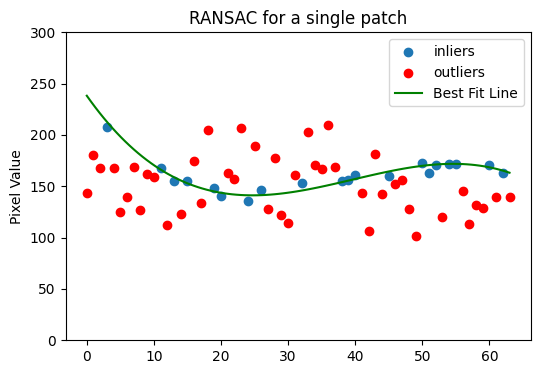

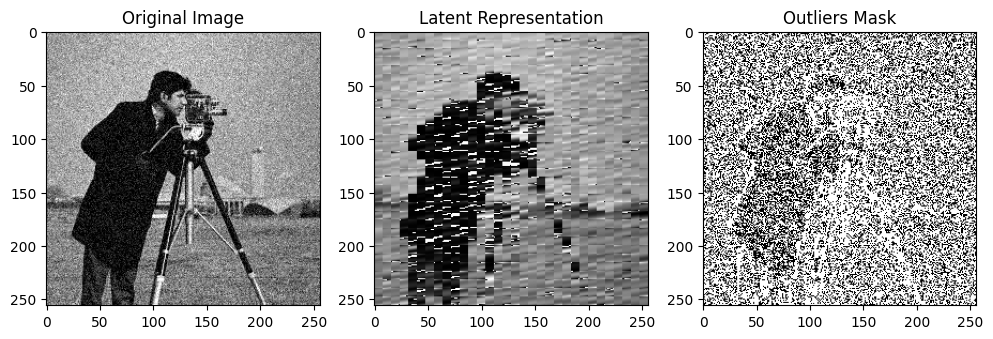

In [20]:
class RANSACEncoder(Encoder):
    def __init__(self, patch_size=8, threshold=10, degree=3, max_iterations=50, min_sample_size=5, plot=False):
        self.patch_size = patch_size
        self.threshold = threshold
        self.degree = degree  # Degree of the polynomial fit
        self.max_iterations = max_iterations
        self.min_sample_size = min_sample_size
        self.plot = plot
    
    def encode(self, image):
        h, w = image.shape
        latent_representation = np.zeros_like(image)
        noise_estimate = np.zeros_like(image, dtype=np.float32)
        outliers_mask = np.zeros_like(image, dtype=np.uint8)
        
        for i in range(0, h, self.patch_size):
            for j in range(0, w, self.patch_size):
                patch = image[i:i+self.patch_size, j:j+self.patch_size].flatten()
                X = np.arange(len(patch)).reshape(-1, 1)
                
                best_model, inliers, residuals = self.run_ransac(X, patch, plot=(i == 0 and j == 0) and self.plot)
                denoised_patch = np.polyval(best_model, X).reshape(self.patch_size, self.patch_size)
                latent_representation[i:i+self.patch_size, j:j+self.patch_size] = denoised_patch
                noise_estimate[i:i+self.patch_size, j:j+self.patch_size] = residuals.reshape(self.patch_size, self.patch_size)

                residuals_patch = residuals.reshape(self.patch_size, self.patch_size)
                outlier_patch = (residuals_patch > self.threshold).astype(np.uint8)
                outliers_mask[i:i+self.patch_size, j:j+self.patch_size] = outlier_patch
         
        return latent_representation.astype(np.uint8), outliers_mask
    
    def run_ransac(self, X, y, plot=False):
        best_model = None
        best_inliers = []
        best_score = 0
        best_residuals = np.zeros_like(y)
        
        for _ in range(self.max_iterations):
            sample_indices = random.sample(range(len(y)), self.min_sample_size)
            sample_X, sample_y = X[sample_indices], y[sample_indices]
            model = np.polyfit(sample_X.flatten(), sample_y, self.degree)
            residuals = np.abs(y - np.polyval(model, X).flatten())
            inliers = y[residuals < self.threshold]
            
            if len(inliers) > best_score:
                best_model = model
                best_inliers = inliers
                best_score = len(inliers)
                best_residuals = residuals
        
        if plot:
            outliers = X[best_residuals > self.threshold]
            outliers_y = y[best_residuals > self.threshold]
            inliers = X[best_residuals <= self.threshold]
            inliers_y = y[best_residuals <= self.threshold]
            self.plot_ransac_results(inliers, outliers, inliers_y, outliers_y, best_model)
        
        return best_model, best_inliers, best_residuals
    
    def plot_ransac_results(self, inliers, outliers, inliers_y, outliers_y, model):
        plt.figure(figsize=(6, 4))
        plt.scatter(inliers, inliers_y, label='inliers')
        plt.scatter(outliers, outliers_y, label='outliers', color='red')
        
        x_line = np.linspace(min(min(inliers), min(outliers)), max(max(inliers), max(outliers)), 100)
        y_line = np.polyval(model, x_line)
        plt.plot(x_line, y_line, label='Best Fit Line', color='green')
        plt.ylim(0, 300)
        
        plt.title('RANSAC for a single patch')
        plt.ylabel('Pixel Value')
        plt.legend()
        plt.show()

encoder = RANSACEncoder(plot=True)
latent_representation, outliers_mask = encoder.encode(original_image)
plot_images(original_image, latent_representation, outliers_mask, titles=["Original Image", "Latent Representation", "Outliers Mask"])

#### SVD Encoder

This idea is based on PCA (Principal Component Analysis), a dimensionality reduction technique that transforms the data into a new coordinate system, often using SVD (Singular Value Decomposition).

SVD is a matrix factorization technique that decomposes a matrix into three matrices: U, S, and V. The U and V matrices contain the left and right singular vectors, respectively, while the S matrix contains the singular values. The singular values represent the importance of each singular vector in reconstructing the original matrix.

$$
X = U \cdot S \cdot V^T
$$

Where:
- $X$ is the original matrix (in this case, the image)
- $U$ is the left singular vector matrix
- $S$ is the diagonal matrix of singular values

The SVD encoder works by performing SVD on the input data and then selecting the top k singular values and their corresponding singular vectors. This effectively reduces the dimensionality of the data while preserving the most important features. The latent representation is then obtained by multiplying the selected singular vectors with the corresponding singular values.

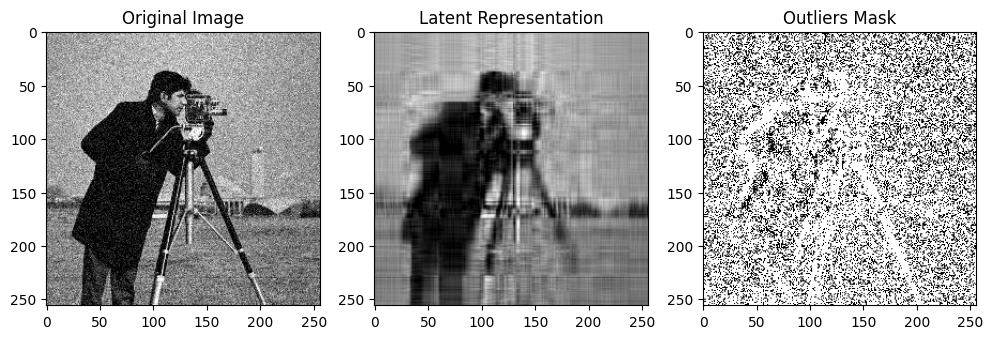

In [5]:
class SVDEncoder(Encoder):
    def __init__(self, patch_size=8, k=10, threshold=20):
        self.patch_size = patch_size
        self.k = k  # Number of singular values to keep
        self.threshold = threshold
    
    def encode(self, image):
        U, S, Vt = np.linalg.svd(image, full_matrices=False)
        S[self.k:] = 0
        latent_representation = (U @ np.diag(S) @ Vt).clip(0, 255).astype(np.uint8)
        noise_estimate = np.abs(image - latent_representation)
        outliers_mask = (noise_estimate > self.threshold).astype(np.uint8)

        return latent_representation, outliers_mask
    
encoder = SVDEncoder()
latent_representation, outliers_mask = encoder.encode(original_image)
plot_images(original_image, latent_representation, outliers_mask, titles=["Original Image", "Latent Representation", "Outliers Mask"])


### Sampler (Decoder):

- The decoder takes the compressed latent representation from the encoder and attempts to reconstruct the original data. 

- In a pseudo-autoencoder, the sampler is the equivalent of the decoder in a traditional autoencoder. The sampler assigns new values to the *outliers* by sampling from the latent space. By using probabilistic methods, the decoder can infer the most likely pixel values, allowing for a more robust yet efficient reconstruction of the original image. The process ensures that the decoder has enough information to regenerate the image by using the latent representation of the original image.
    

#### Mean Sampler

The mean sampler takes the mean of the pixel values in a local neighborhood around each outlier pixel. This helps to smooth out noise while preserving the overall structure of the image.

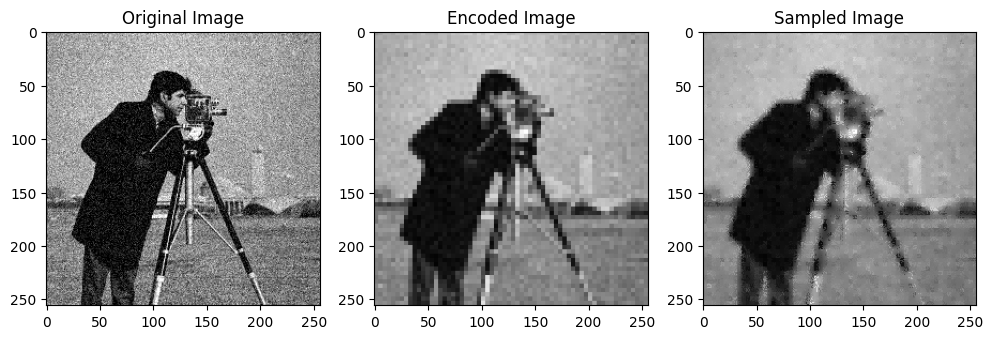

In [89]:
class MeanSampler(Sampler):
    def __init__(self, patch_size=4):
        self.patch_size = patch_size

    def sample(self, image, outliers_mask):
        h, w = image.shape
        sampled_image = image.copy()

        for x, y in zip(*np.where(outliers_mask == 1)):
            patch = sampled_image[max(x-self.patch_size, 0):min(h, x+self.patch_size+1),
                                    max(y-self.patch_size, 0):min(w, y+self.patch_size+1)]
            sampled_image[x, y] = np.mean(patch)
        
        return sampled_image.astype(np.uint8)

encoder = MeanEncoder(patch_size=4)
latent_representation, outliner_mask = encoder.encode(original_image)

sampler = MeanSampler()
sampled_image = sampler.sample(latent_representation, outliner_mask)
plot_images(original_image, latent_representation, sampled_image)

#### MCMC Sampler

MCMC (Markov Chain Monte Carlo) is a class of algorithms that sample from a probability distribution by constructing a Markov chain. The chain is designed to converge to the target distribution, allowing for efficient sampling.

$$
\text{MCMC}(X) = \frac{1}{Z} \sum_{i=1}^{N} p(X_i | \theta) \cdot p(\theta)
$$

Where $Z$ is the normalization constant, $N$ is the number of samples, $p(X_i | \theta)$ is the likelihood of the data given the parameters $\theta$, and $p(\theta)$ is the prior distribution of the parameters.

The MCMC sampler works by iteratively updating the pixel values of the outliers based on the latent representation. The algorithm uses a proposal distribution (Gaussian) to generate new pixel values and accepts or rejects them based on the acceptance threshold. This process allows the sampler to explore the latent space and generate new pixel values that are consistent with the latent representation.

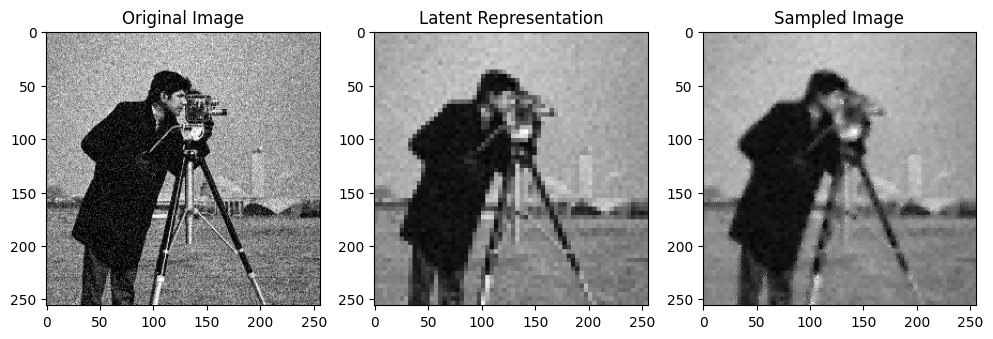

In [8]:
class MCMCSampler(Sampler):
    def __init__(self, iterations=100, sigma=5, threshold=20):
        self.iterations = iterations
        self.sigma = sigma
        self.threshold = threshold

    def sample(self, image, outliers_mask):
        h, w = image.shape
        sampled_image = image.copy()

        for x, y in zip(*np.where(outliers_mask == 1)):
            current_value = sampled_image[x, y]
            for _ in range(self.iterations):
                proposed_value = np.random.normal(current_value, self.sigma)

                if (0 <= proposed_value <= 255 and 
                    abs(proposed_value - current_value) < self.threshold):
                    current_value = proposed_value
            sampled_image[x, y] = current_value

        return sampled_image.astype(np.uint8)
    
encoder = MeanEncoder(patch_size=4)
latent_representation, outliner_mask = encoder.encode(original_image)

sampler = MeanSampler()
sampled_image = sampler.sample(latent_representation, outliner_mask)
plot_images(original_image, latent_representation, sampled_image)

#### Importance Sampler

Importance Sampling is used to estimate properties of a particular distribution while only having samples generated from a different distribution. The key idea is to re-weight the samples based on their importance to the target distribution. 

$$
\hat{I} = \frac{1}{N} \sum_{i=1}^{N} \frac{p(x_i)}{q(x_i)} f(x_i)
$$

Where:
- $\hat{I}$ is the estimate of the integral
- $N$ is the number of samples
- $p(x_i)$ is the target distribution
- $q(x_i)$ is the proposal distribution
- $f(x_i)$ is the function we want to integrate
- $x_i$ is the sample from the proposal distribution

The target distribution here is the latent representation of the image. The importance sampler works by assigning weights to the samples based on their likelihood of being generated from the target distribution. The algorithm then samples from the weighted distribution to generate new pixel values for the outliers.

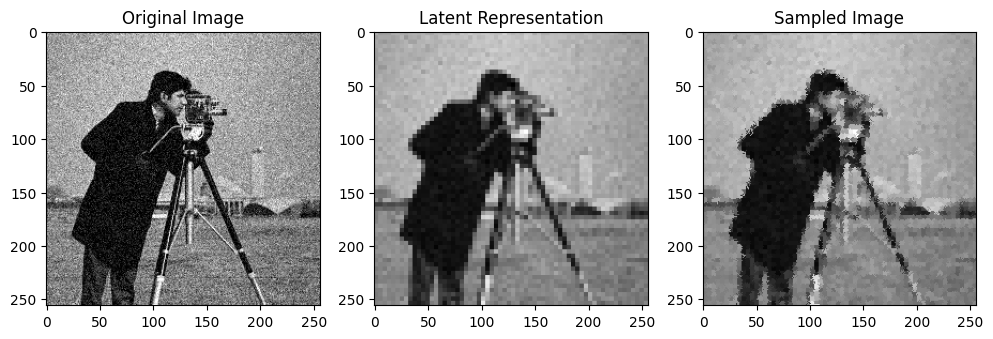

In [18]:
class ImportanceSampler(Sampler):
    def __init__(self, patch_size=1):
        self.patch_size = patch_size

    def sample(self, image, outliers_mask):
        h, w = image.shape
        sampled_image = image.copy()

        for x, y in zip(*np.where(outliers_mask == 1)): 
            patch = sampled_image[max(x-self.patch_size, 0):min(h, x+self.patch_size+1),
                                    max(y-self.patch_size, 0):min(w, y+self.patch_size+1)]
            patch_weights = patch / np.sum(patch, dtype=np.float32)
            patch_flat = patch.flatten()
            patch_weights_flat = patch_weights.flatten()

            sampled_value = np.random.choice(patch_flat, p=patch_weights_flat)
            sampled_image[x, y] = sampled_value

        return sampled_image.astype(np.uint8)
    
encoder = MeanEncoder(patch_size=4)
latent_representation, outliner_mask = encoder.encode(original_image)

sampler = ImportanceSampler()
sampled_image = sampler.sample(latent_representation, outliner_mask)
plot_images(original_image, latent_representation, sampled_image)

## Coding Challenge

I have implemented three different encoders and samplers for my variations for the pseudo-autoencoder. There are several parameters to tune as well, such as the size of the patches, and the acceptance threshold. The challenge is to combine them in a way that achieves the best denoising results for this particular image.

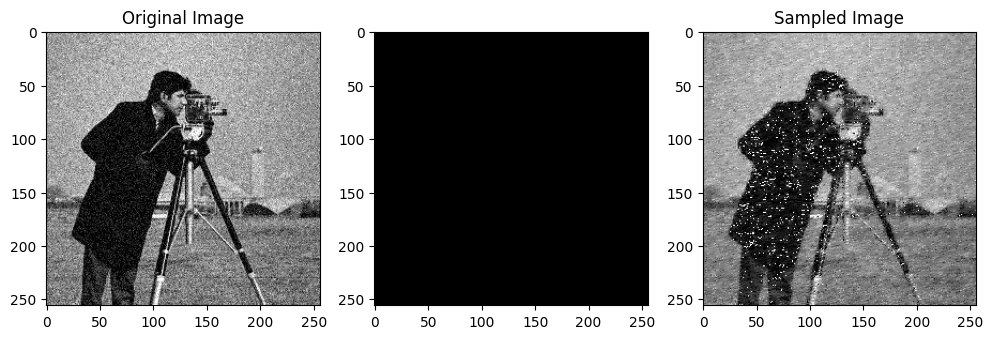

In [30]:
encoder = RANSACEncoder(patch_size=4, threshold=20, degree=4)
sampler = MeanSampler()

latent_representation, sampled_image = pseudo_autoencoder(original_image, encoder, sampler)
plot_images(original_image, np.zeros_like(original_image), sampled_image, titles=["Original Image", "", "Sampled Image"])

## Evaluation

The pseudo-autoencoder is only a proof of concept. The results are not as good as the traditional autoencoder, but the process does not require machine learning, and can be easily implemented. Further improvements can be made to this project by using more advanced statistical methods, such as Gaussian Mixture Models (GMM) or Hidden Markov Models (HMM) which can capture the spatial correlations in the data, as well as the local structure of the image.

## References

- [Image Denoising Using Convolutional Autoencoder](https://arxiv.org/pdf/2207.11771)
- [RANSAC algorithm](https://en.wikipedia.org/wiki/Random_sample_consensus)
- [Random Walk](https://en.wikipedia.org/wiki/Random_walk)
- [Image Dataset](https://links.uwaterloo.ca/Repository.html)